In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [2]:
# Load CIFAR-10 dataset and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


In [3]:
# Define the DenseNet model for fine-tuning
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [4]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images by 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom images by 10%
)


In [5]:
# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# # Define ModelCheckpoint callback to save the best model during training
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [6]:
# Train the model using the validation set for monitoring
batch_size = 384
epochs = 100
# history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

# Calculate the number of steps per epoch
steps_per_epoch = len(x_train) // batch_size

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
117/117 [==============================] - 37s 160ms/step - loss: 2.5155 - accuracy: 0.1425 - val_loss: 2.1909 - val_accuracy: 0.3032
Epoch 2/100
117/117 [==============================] - 18s 149ms/step - loss: 2.0057 - accuracy: 0.2697 - val_loss: 1.7220 - val_accuracy: 0.4900
Epoch 3/100
117/117 [==============================] - 18s 155ms/step - loss: 1.5855 - accuracy: 0.4301 - val_loss: 1.2571 - val_accuracy: 0.6164
Epoch 4/100
117/117 [==============================] - 20s 167ms/step - loss: 1.2758 - accuracy: 0.5622 - val_loss: 0.9617 - val_accuracy: 0.6928
Epoch 5/100
117/117 [==============================] - 19s 159ms/step - loss: 1.0679 - accuracy: 0.6479 - val_loss: 0.7859 - val_accuracy: 0.7508
Epoch 6/100
117/117 [==============================] - 19s 163ms/step - loss: 0.9255 - accuracy: 0.7026 - val_loss: 0.7338 - val_accuracy: 0.7692
Epoch 7/100
117/117 [==============================] - 19s 159ms/step - loss: 0.8247 - accuracy: 0.7430 - val_loss: 0.6299 -

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

27/27 [==============================] - 1s 27ms/step - loss: 0.6075 - accuracy: 0.8755
Test Loss: 0.6074983477592468
Test Accuracy: 0.8755000233650208


In [8]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

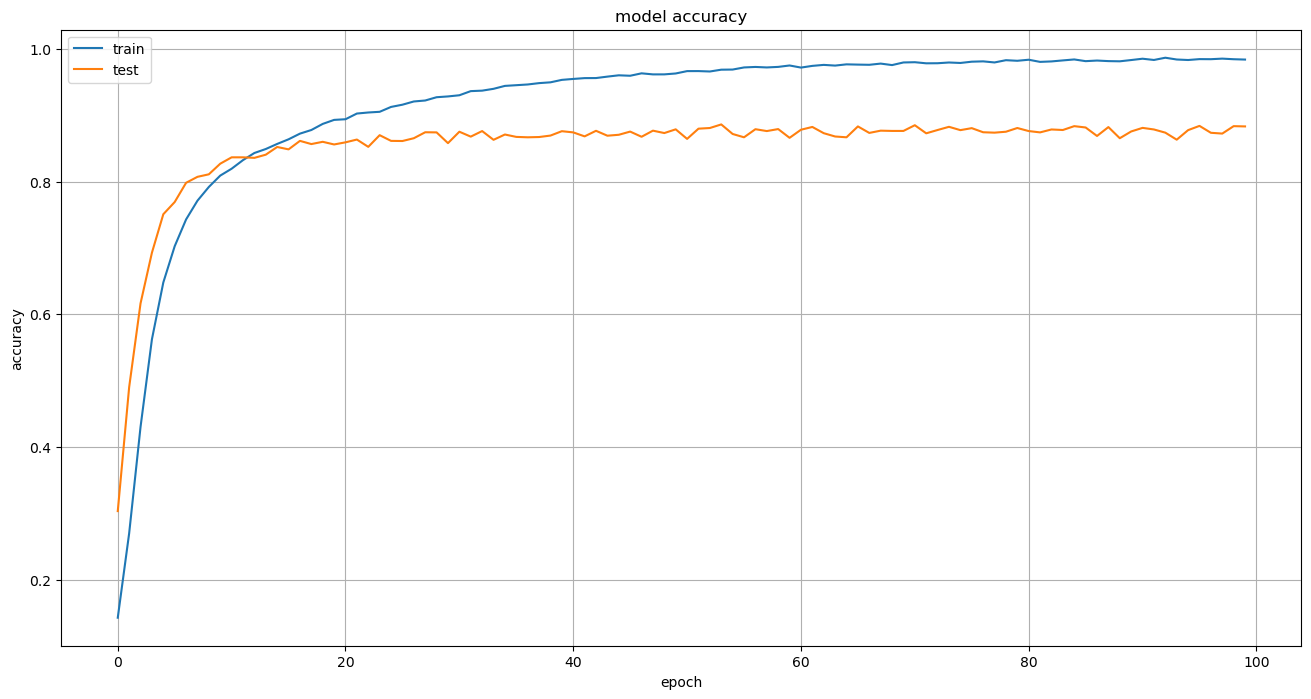

In [9]:
plothist(history)

In [10]:
# plotting helper function
def plothist_loss(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

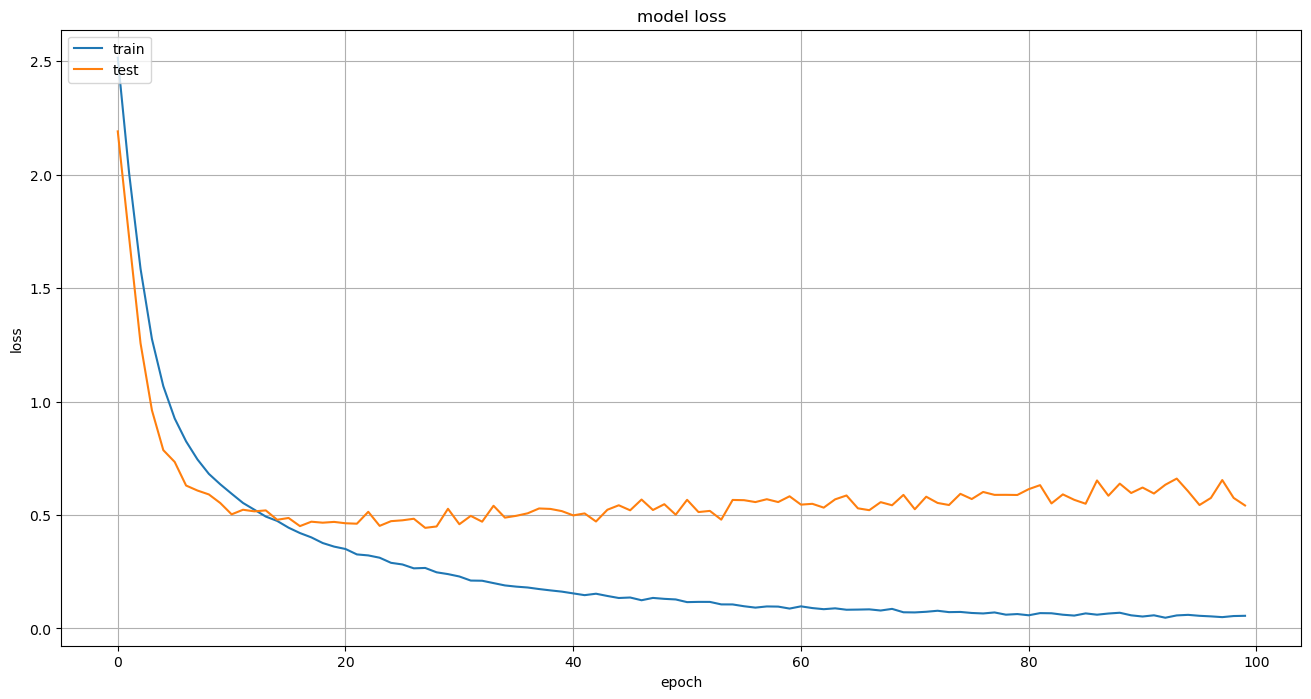

In [11]:
plothist_loss(history)

In [12]:
# Save the trained model
model.save('trained_model.h5')